# Model hiper optimization

<h1 style='color:red'>Not working: it only predicts 060</h1>

In [35]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [36]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0 - 060_010 recall with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [37]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [38]:
# using only last year
split_date = "2018-01-01"
df = df[df["FECHA_SINI"] >= split_date].copy()

In [39]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [40]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[(df["TIPO_EXPED"] == 6) |( df["TIPO_EXPED"] == 3)]
df_val = df_val[(df_val["TIPO_EXPED"] == 6) | (df_val["TIPO_EXPED"] == 3)]

In [41]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,220235,648
1.0,3766,7
2.0,2436,95
3.0,5776,73
4.0,739,20
5.0,739,481
6.0,58,43
7.0,100,83
8.0,80,63


In [42]:
df["TIPO_EXPED"].value_counts()

3    203555
6     32020
Name: TIPO_EXPED, dtype: int64

In [43]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [44]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_32', 'cond_C10', 'cond_C11', 'cond_C12', 'cond_C13', 'cond_C14',
       'cond_C15', 'cond_C16', 'cond_C18', 'cond_C19', 'cond_C20'],
      dtype='object')

In [45]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [46]:
df["cant_cond"].value_counts()

0    220883
1     13217
2      1355
3       112
4         8
Name: cant_cond, dtype: int64

In [47]:
df["EXISTE_FRAUDE"].value_counts()

False    234001
True       1574
Name: EXISTE_FRAUDE, dtype: int64

In [48]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [49]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [50]:
# using only last year
split_date = "2018-09-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-08-31 00:00:00
2018-09-01 00:00:00 2019-01-31 00:00:00


In [51]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.994475
 True     0.005525
 Name: EXISTE_FRAUDE, dtype: float64, False    0.991437
 True     0.008563
 Name: EXISTE_FRAUDE, dtype: float64)

In [52]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.6192974636527645, 0.3807025363472355)

In [53]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [54]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [55]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [56]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [57]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

145891, 89684
145891, 89684


In [58]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.005524672529491195, 0.008563400383568976)

In [59]:
y_train.value_counts(dropna=False)

False    145085
True        806
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [60]:
from sklearn.utils.class_weight import compute_class_weight

In [61]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([ 0.50336323, 74.83322745])

In [65]:
# configs
list_weights = [25, 12]
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 25}, {0: 1, 1: 12}]

**VERSION SIMPLE**

In [66]:

rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 12}],
  'bootstrap': [False, True]},
 {'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 12}],
  'bootstrap': [False, True]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [25, 12]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 12}]}]

**VERSION COMPLEJA**

In [ ]:

rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)
gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 5],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [15, 40, -1],
    'min_child_samples': [3, 5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
param_configs.append(lgbm_params)
param_configs

In [67]:
# using without grid with list of models
rfs = []
rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(XGBClassifier(random_state=random_state))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators='warn',
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 XGBClassifier(ba

In [68]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Comparing 48 parameter setting(s) using 2 CPU thread(s) ( 24 job(s) per thread ).


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

Best score: 0.7291666666666666
Best config: {'bootstrap': False, 'class_weight': {0: 1, 1: 25}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
Comparing 48 parameter setting(s) using 2 CPU thread(s) ( 24 job(s) per thread ).


/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/seba/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed paral

Best score: 0.6901041666666666
Best config: {'bootstrap': False, 'class_weight': {0: 1, 1: 25}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 2: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 12 parameter setting(s) using 2 CPU thread(s) ( 6 job(s) per thread ).
Best score: 0.7877604166666666
Best config: {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 25}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 3: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsampl

In [69]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=RandomForestClassifier(bootstrap=False,
                                        class_weight={0: 1, 1: 25},
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=-1,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False),
           num_threads=2,
           param_grid={'bootstrap': [False, True],
                       'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 12}],
                       'max_depth': [10, 40],

In [70]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[1]

In [71]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.788 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 25}
0.781 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 25}
0.781 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 25}
0.780 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 25}
0.661 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 12}
0.648 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 12}
0.612 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 12}
0.612 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 12}
0.477 for {'learning_rate': 1.0, 'n_estimators': 60, 'scale_pos_weight': 25}
0.435 for {'learning_rate': 1.0, 'n_estimators': 100, 'scale_pos_weight': 25}
0.405 for {'learning_rate': 1.0, 'n_estimators': 60, 'scale_pos_weight': 12}
0.368 for {'learning_rate': 1.0, 'n_estimators': 100, 'scale_pos_weight': 12}


In [85]:
y_opt_pred = best_model.predict(X_opt)
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.46476901539897336, 0.819287129144361)

In [86]:
confusion_matrix(y_opt, y_opt_pred)

array([[88039,   877],
       [  270,   498]])

In [101]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
3              76011     1    23     0
6              12026   878   249   496

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

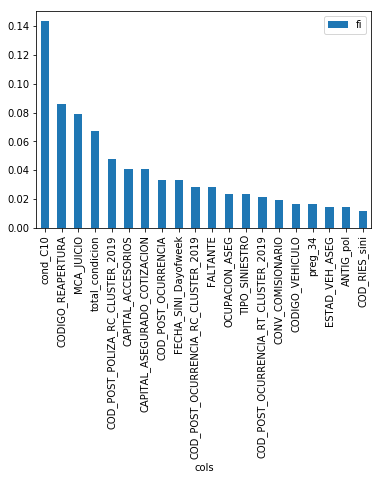

In [91]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [92]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 37 of 96


In [75]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [93]:
# best model
best_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=60,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=12,
              seed=0, silent=True, subsample=1)

### Training again with less features

In [94]:
X_train_red = X_train[to_keep].copy()
print(len(X_train_red.columns))

37


In [95]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=60,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=12,
              seed=0, silent=True, subsample=1)

In [102]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.4629024731684555, 0.8179737992412315)

In [103]:
confusion_matrix(y_opt, y_opt_pred)

array([[88037,   879],
       [  272,   496]])

In [104]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
3              76011     1    23     0
6              12026   878   249   496

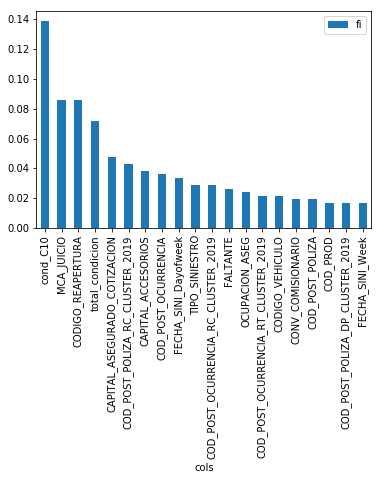

In [98]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [75]:
best_model = copy(rf)

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

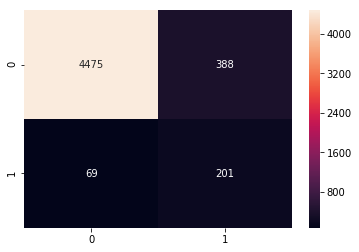

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [84]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [85]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.471, 0.898


In [86]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4477,  386],
       [  68,  202]])

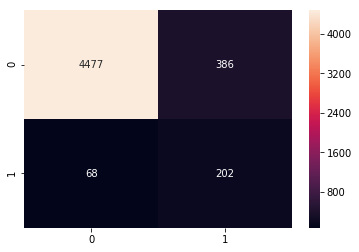

In [87]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [81]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.470873786407767,0.8222450704868967)


In [82]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[4503,  360],
       [  76,  194]])

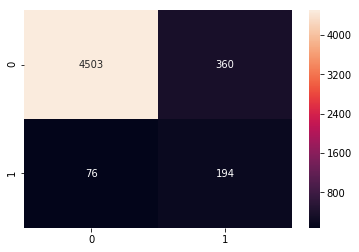

In [83]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [88]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [89]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [90]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [91]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['total_condicion', 'cond_C10', 'CODIGO_VEHICULO', 'CODIGO_REAPERTURA', 'preg_34', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'FECHA_SINI_Elapsed', 'ANTIG_pol', 'FECHA_SINI_Dayofyear', 'CODIGO_CARATULA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_RIES_sini', 'preg_33', 'TIPO_SINIESTRO', 'SEGMENTO', 'CAPITAL_VEHICULO', 'ESTAD_VEH_ASEG', 'ESTADO_CIVIL', 'COD_PROD', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_15', 'FALTANTE', 'CANT_RENOVACION', 'CAPITAL_ACCESORIOS', 'DESCRIPCION_TIPO', 'preg_32', 'COD_ZONA_ROBO', 'SEXO', 'cond_C15', 'cant_sini_1y', 'cond_C11', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'COD_RAMO_sini', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'COD_ZONA_RC', 'cond_C12', 'cond_C13', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'preg_31']


In [92]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [120]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [3]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [4]:
df_test = df_test[df_test["TIPO_EXPED"] == 6]

In [95]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [96]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [97]:
print(columns)

['total_condicion', 'cond_C10', 'CODIGO_VEHICULO', 'CODIGO_REAPERTURA', 'preg_34', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'FECHA_SINI_Elapsed', 'ANTIG_pol', 'FECHA_SINI_Dayofyear', 'CODIGO_CARATULA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_RIES_sini', 'preg_33', 'TIPO_SINIESTRO', 'SEGMENTO', 'CAPITAL_VEHICULO', 'ESTAD_VEH_ASEG', 'ESTADO_CIVIL', 'COD_PROD', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_15', 'FALTANTE', 'CANT_RENOVACION', 'CAPITAL_ACCESORIOS', 'DESCRIPCION_TIPO', 'preg_32', 'COD_ZONA_ROBO', 'SEXO', 'cond_C15', 'cant_sini_1y', 'cond_C11', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'COD_RAMO_sini', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'COD_ZONA_RC', 'cond_C12', 'cond_C13', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'preg_31']


In [98]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

In [99]:
X_test.head()

,total_condicion,cond_C10,CODIGO_VEHICULO,CODIGO_REAPERTURA,preg_34,COD_POST_OCURRENCIA,COD_POST_POLIZA,OCUPACION_ASEG,COD_POST_OCURRENCIA_RC_CLUSTER_2019,FECHA_SINI_Elapsed,ANTIG_pol,FECHA_SINI_Dayofyear,CODIGO_CARATULA,COD_POST_POLIZA_RC_CLUSTER_2019,COD_RIES_sini,preg_33,TIPO_SINIESTRO,SEGMENTO,CAPITAL_VEHICULO,ESTAD_VEH_ASEG,ESTADO_CIVIL,COD_PROD,CAPITAL_ASEGURADO_COTIZACION,preg_15,FALTANTE,CANT_RENOVACION,CAPITAL_ACCESORIOS,DESCRIPCION_TIPO,preg_32,COD_ZONA_ROBO,SEXO,cond_C15,cant_sini_1y,cond_C11,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_POLIZA_DP_CLUSTER_2019,COD_COBRO_ANTERIOR,COD_RAMO_sini,FECHA_SINI_Week,FECHA_SINI_Month,COD_ZONA_RC,cond_C12,cond_C13,COD_POST_POLIZA_RT_CLUSTER_2019,preg_31
11,2.0,0.0,12415.0,-1.0,270,5010.0,5010.0,5.0,18.0,1554076800,455.0,91.0,-1.0,18.0,1.0,1,5,4,1324,3.0,6,5010.0,778,-1,0,16.0,8,3,1,7.0,1,0.0,0.0,0.0,3.0,19.0,0,1.0,14.0,4.0,8.0,0.0,0.0,3.0,0
13,2.0,0.0,21763.0,-1.0,-1,1759.0,1759.0,28.0,25.0,1554076800,608.0,91.0,-1.0,25.0,1.0,1,5,4,424,3.0,6,6030.0,317,-1,1,21.0,8,3,1,1.0,1,0.0,0.0,0.0,10.0,29.0,5,1.0,14.0,4.0,1.0,0.0,0.0,10.0,1
23,5.0,0.0,2035.0,-1.0,293,1754.0,1766.0,8.0,25.0,1554076800,1034.0,91.0,-1.0,25.0,1.0,1,7,4,2781,3.0,6,6030.0,1475,-1,0,35.0,182,2,1,1.0,1,0.0,0.0,0.0,10.0,29.0,5,1.0,14.0,4.0,1.0,3.0,0.0,10.0,0
24,3.0,0.0,2116.0,-1.0,270,1766.0,1766.0,5.0,25.0,1554076800,676.0,91.0,-1.0,25.0,1.0,0,5,-1,5618,5.0,0,72189.0,2818,-1,1,24.0,8,3,0,1.0,1,0.0,0.0,0.0,10.0,29.0,2,8.0,14.0,4.0,1.0,3.0,0.0,10.0,0
30,0.0,0.0,28512.0,-1.0,270,5000.0,5000.0,13.0,18.0,1554076800,516.0,91.0,-1.0,18.0,1.0,1,5,5,7555,3.0,9,72043.0,3534,-1,1,18.0,8,23,0,7.0,1,0.0,1.0,0.0,3.0,19.0,2,1.0,14.0,4.0,8.0,0.0,0.0,3.0,0


## Model in test

In [100]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.393, 0.893


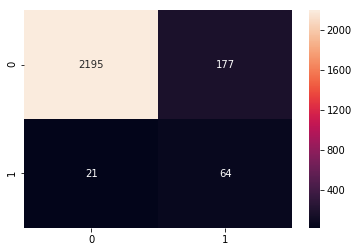

In [127]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [128]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.444, 0.842


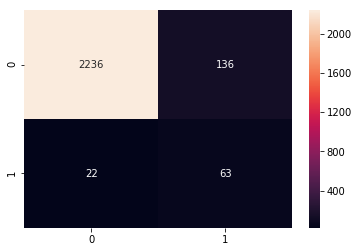

In [129]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [5]:
pd.crosstab(df_test["total_condicion"],df_test["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,1595,10
1.0,134,1
2.0,239,1
3.0,251,10
4.0,17,0
5.0,80,30
6.0,23,5
7.0,3,3
8.0,15,6
